
Mean images in each category

Plot of error when using PCA 20


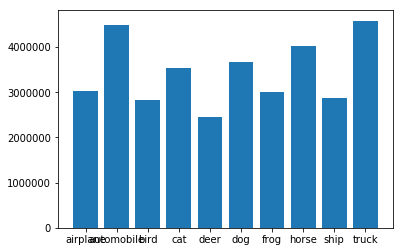


Mean distance


,0,1,2,3,4,5,6,7,8,9
0,0.000000,1834.101415,1711.634599,2027.760094,2349.357359,1991.162726,2556.765535,1719.123614,1084.982949,1513.963672
1,1834.101415,0.000000,908.030286,1043.826135,1180.504130,1216.553739,1188.214627,944.744410,1288.484381,994.302771
2,1711.634599,908.030286,0.000000,516.238317,690.267340,658.833818,919.684185,455.821237,1540.931861,1410.780989
3,2027.760094,1043.826135,516.238317,0.000000,514.417146,477.727956,674.235122,634.840925,1864.484647,1672.797358
4,2349.357359,1180.504130,690.267340,514.417146,0.000000,718.430929,424.325347,821.303841,2117.221764,1876.926743
5,1991.162726,1216.553739,658.833818,477.727956,718.430929,0.000000,902.028270,834.124091,1845.342516,1837.569318
6,2556.765535,1188.214627,919.684185,674.235122,424.325347,902.028270,0.000000,994.340988,2230.945539,1910.186378
7,1719.123614,944.744410,455.821237,634.840925,821.303841,834.124091,994.340988,0.000000,1573.712172,1268.499113
8,1084.982949,1288.484381,1540.931861,1864.484647,2117.221764,1845.342516,2230.945539,1573.712172,0.000000,1041.952014
9,1513.963672,994.302771,1410.780989,1672.797358,1876.926743,1837.569318,1910.186378,1268.499113,1041.952014,0.000000



2D Map


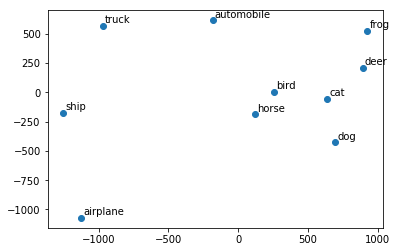


Cross PCA Error


,0,1,2,3,4,5,6,7,8,9
0,3022336.0,3297767.0,3163016.0,3171688.0,3040928.0,3258014.0,3222113.0,3192430.0,3128729.0,3545089.0
1,3297767.0,4494599.0,5103854.0,4897970.0,4878721.0,5013777.0,5024591.0,4990063.0,4843493.0,4725028.0
2,3163016.0,5103854.0,2831360.0,2949790.0,2996513.0,2967889.0,3049771.0,3198724.0,3329644.0,3475336.0
3,3171688.0,4897970.0,2949790.0,3541784.0,3844857.0,3671002.0,3815447.0,3957333.0,4143426.0,4019296.0
4,3040928.0,4878721.0,2996513.0,3844857.0,2454821.0,2652693.0,2644224.0,2733563.0,2732969.0,2959463.0
5,3258014.0,5013777.0,2967889.0,3671002.0,2652693.0,3671677.0,3968456.0,4121901.0,4477871.0,4259986.0
6,3222113.0,5024591.0,3049771.0,3815447.0,2644224.0,3968456.0,3015748.0,3346221.0,3364636.0,3430642.0
7,3192430.0,4990063.0,3198724.0,3957333.0,2733563.0,4121901.0,3346221.0,4035582.0,4531884.0,4508628.0
8,3128729.0,4843493.0,3329644.0,4143426.0,2732969.0,4477871.0,3364636.0,4531884.0,2862990.0,3242742.0
9,3545089.0,4725028.0,3475336.0,4019296.0,2959463.0,4259986.0,3430642.0,4508628.0,3242742.0,4584847.0


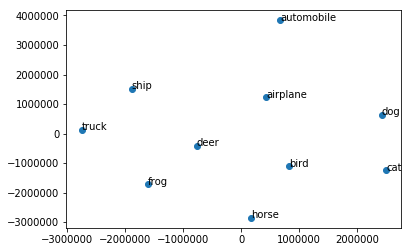

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics import euclidean_distances
from scipy.spatial import distance
import os
import sys

%matplotlib inline

cifar_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

class Hw3:
    
    X = [None]*10 # List of DataFrames
    X_mean = [None]*10 # List of np.array
    X_centered = [None]*10 # List of DataFrames (centered for PCA)
    X_pca = [None]*10 # List of PCA models
    pca_err = [None]*10
    pca_x_err = np.zeros((10,10))
    similarities = None
    
    def __init__(self):
        self.load()
        
    def unpickle(self, file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    def load(self):
        
        meta = self.unpickle("cifar-10-batches-py/batches.meta")
        X = pd.DataFrame()
        Y = pd.DataFrame()
        
        # use range(1,1) when developing (faster), range(1,6) for full data
        for i in range(1,1):
            data = self.unpickle("cifar-10-batches-py/data_batch_" + str(i))
            X = pd.concat([X, pd.DataFrame(data[b'data'])])
            Y = pd.concat([Y, pd.DataFrame(data[b'labels'])])
        
        # Adding the test batch
        data = self.unpickle("cifar-10-batches-py/test_batch")
        X = pd.concat([X, pd.DataFrame(data[b'data'])])
        Y = pd.concat([Y, pd.DataFrame(data[b'labels'])])
        
        X['label'] = Y
        X_groups = X.groupby('label')
        for i in range(0,10):
            self.X[i] = X_groups.get_group(i).drop('label', axis=1).reset_index(drop=True)
            self.X_mean[i] = self.X[i].mean().astype('uint8').values
            self.X_centered[i] = self.X[i] - self.X_mean[i]
    
    def draw(self, xi):
        plt.imshow(np.dstack((xi[0:1024].reshape(32,32), xi[1024:2048].reshape(32,32), xi[2048:3072].reshape(32,32))))
        plt.show()
    
    def drawMean(self, label):
        print (cifar_labels[label])
        self.draw(self.X_mean[label])
        
    def computePCA(self, label):
        pca = PCA(n_components=20)
        pca.fit(self.X_centered[label])
        self.X_pca[label] = pca        
        
    def part1_draw_mean(self):
        for i in range(0,10):
            self.drawMean(i)
            
    def part1_compute_pca(self):
        for i in range(0,10):
            self.computePCA(i)        
            
    def part1_calculate_error_option1(self):
        for i in range(0,10):
            components = self.X_pca[i].transform(self.X_centered[i])
            inv = self.X_pca[i].inverse_transform(components)
            var = self.X_pca[i].explained_variance_
            varDF = pd.DataFrame(var)
            varPlot = var[20:3071]
            varPlot = pd.DataFrame(varPlot)
            sumVar = sum(varPlot.values)
            self.pca_err[i] = int(sumVar[0])
            
    def part1_calculate_error_option2(self):
        for i in range(0,10):
            X = self.X[i].astype('float')
            component = self.X_pca[i].transform(X)
            inv = pd.DataFrame(self.X_pca[i].inverse_transform(component))
            self.pca_err[i] = int(np.square(X-inv).sum(axis=1).mean())            
            
    def part1_plot_error(self):
        global cifar_labels
        plt.figure()
        plt.bar(cifar_labels, self.pca_err)
        plt.show()
                
    def part2_mean_distances(self):
        self.similarities = euclidean_distances(self.X_mean)
        display(pd.DataFrame(self.similarities))
        
    def part2_2d_map(self):
        global cifar_labels
        mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=10, dissimilarity="precomputed", n_jobs=1)
        pos = mds.fit(self.similarities).embedding_
        plt.figure()
        plt.scatter(pos[:,0], pos[:,1])
        for i in range (0,10):
            xy=(pos[i][0]+15,pos[i][1]+25)
            plt.annotate(cifar_labels[i],xy)
        plt.show()
        
    def part3_calculate_cross_error(self):
        for i in range(0,10):
            for j in range(i,10):
                X = self.X[i].astype('float')
                pca = self.X_pca[j]
                component = pca.transform(X)
                inv = pd.DataFrame(pca.inverse_transform(component))
                error = int(np.square(X-inv).sum(axis=1).mean())
                self.pca_x_err[i][j] = error
                self.pca_x_err[j][i] = error
        
        display(pd.DataFrame(self.pca_x_err))
        
        global cifar_labels
        mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=10, dissimilarity="precomputed", n_jobs=1)
        pos = mds.fit(self.pca_x_err).embedding_
        plt.figure()
        plt.scatter(pos[:,0], pos[:,1])
        for i in range (0,10):
            xy=(pos[i][0]+15,pos[i][1]+25)
            plt.annotate(cifar_labels[i],xy)
        plt.show()        
        

hw = Hw3()
print("\nMean images in each category")
# hw.part1_draw_mean()
hw.part1_compute_pca()
hw.part1_calculate_error_option2()
print("\nPlot of error when using PCA 20")
hw.part1_plot_error()

print("\nMean distance")
hw.part2_mean_distances()

print("\n2D Map")
hw.part2_2d_map()

print("\nCross PCA Error")
hw.part3_calculate_cross_error()



In [138]:
pd.DataFrame(hw.similarities)

,0,1,2,3,4,5,6,7,8,9
0,0.000000,1834.101415,1711.634599,2027.760094,2349.357359,1991.162726,2556.765535,1719.123614,1084.982949,1513.963672
1,1834.101415,0.000000,908.030286,1043.826135,1180.504130,1216.553739,1188.214627,944.744410,1288.484381,994.302771
2,1711.634599,908.030286,0.000000,516.238317,690.267340,658.833818,919.684185,455.821237,1540.931861,1410.780989
3,2027.760094,1043.826135,516.238317,0.000000,514.417146,477.727956,674.235122,634.840925,1864.484647,1672.797358
4,2349.357359,1180.504130,690.267340,514.417146,0.000000,718.430929,424.325347,821.303841,2117.221764,1876.926743
5,1991.162726,1216.553739,658.833818,477.727956,718.430929,0.000000,902.028270,834.124091,1845.342516,1837.569318
6,2556.765535,1188.214627,919.684185,674.235122,424.325347,902.028270,0.000000,994.340988,2230.945539,1910.186378
7,1719.123614,944.744410,455.821237,634.840925,821.303841,834.124091,994.340988,0.000000,1573.712172,1268.499113
8,1084.982949,1288.484381,1540.931861,1864.484647,2117.221764,1845.342516,2230.945539,1573.712172,0.000000,1041.952014
9,1513.963672,994.302771,1410.780989,1672.797358,1876.926743,1837.569318,1910.186378,1268.499113,1041.952014,0.000000


,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,202,202,204,206,208,209,210,212,213,215,...,127,149,174,195,212,227,237,243,243,243


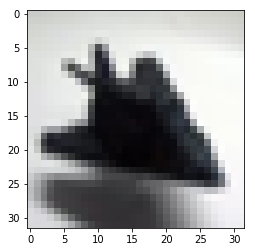

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,196,197,201,202,203,206,208,208,213,215,...,259,254,248,244,243,241,238,233,231,235


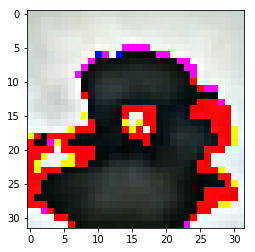

In [93]:
x = hw.X[0].iloc[0].astype('uint8')
display(pd.DataFrame([x]))
hw.draw(x)
mean = hw.X_mean[0]
centered = np.array(x) - np.array(mean)
#display(pd.DataFrame([centered]))
#x_again = centered + np.array(mean)
#hw.draw(pd.Series(x_again))
component = hw.X_pca[0].transform(pd.DataFrame([centered]))
inv = hw.X_pca[0].inverse_transform(component)

x_again = inv + np.array(mean)
display(pd.DataFrame(x_again).astype('uint32'))
hw.draw(pd.DataFrame(x_again).astype('uint32').iloc[0])


#display(pd.DataFrame([hw.X_centered[0]]).shape)
#components = hw.X_pca[1].transform(hw.X_centered[0])
#inv = hw.X_pca[1].inverse_transform(components)
#pd.DataFrame(inv)
#var = self.X_pca[i].explained_variance_
#varDF = pd.DataFrame(var)
#varPlot = var[20:3071]
#varPlot = pd.DataFrame(varPlot)
#sumVar = sum(varPlot.values)
#self.pca_err[i] = int(sumVar[0])